**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, Reshape, BatchNormalization

### ADDED
skvideo.setFFmpegPath("/usr/local/bin")
from random import randint
import matplotlib.pyplot as plt
###

### ADDED
from keras.layers import Dropout, Flatten
###

Using Theano backend.


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

__Answer 1__

The function act works in the following way :

• when the agent is learning an optimal policy, the agent has to explore the environment. It is why $\epsilon$ is important, because at each state, the agent has a probability of $\epsilon$ to choose a random action, and a probability of $1-\epsilon$ to choose an action according to the current policy.

• when the agent has learnt an optimal policy, the agent just follow it.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        
        # coordinate of the cat
        self.x = 0
        self.y = 1
        
        # self time
        self.t = 0
        
        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board > 0,0] = 256
        b[self.board < 0,2] = 256
        b[self.x,self.y,:] = 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))
        
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        ### MODIFIED
        #self.position[-2:,:] = -1
        self.position[:,-2:] = -1
        ###
        
        self.position[self.x, self.y] = 1
        
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')
        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        
        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0
        
        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        ### MODIFIED
        #self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        ###
        
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1), self.position.reshape(self.grid_size, self.grid_size,1)), axis=2)
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=60 # set small when debugging
epochs_test=20 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

__Answer 2__

For a grid of size $10\times10$,

Position is the matrix of location :
$$
\begin{matrix}
    -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. \\
    -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 1. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & -1. & -1. \\
    -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. \\
    -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1. & -1.    
\end{matrix}
$$
where $1$ is the agent location, $0$ correspond to the location of where the agent can go, and $-1$ correspond to the location of where agent can't go.

And Board is the matrix of reward :
$$
\begin{matrix}
    0. & 0. & -1. & -1. & 0. & -1. & 0. & -1. & 0.5 & 0.5 & -1. & 0. & -1. & 0. \\
    -1. & 0. & 0.5 & 0.5 & -1. & -1. & 0. & -1. & 0. & 0.5 & 0. & 0. & 0. & -1. \\
    -1. & 0.5 & 0. & 0. & 0. & 0. & 0.5 & 0.5 & -1. & 0.5 & -1. & 0. & 0. & 0.5 \\
    0. & -1. & 0. & 0. & 0.5 & 0. & 0. & 0. & 0.5 & 0. & -1. & 0. & 0. & -1. \\
    0.5 & 0. & -1. & 0. & -1. & -1. & -1. & 0. & 0. & -1. & 0. & 0. & 0. & 0. \\
    -1. & 0. & -1. & 0. & -1. & 0. & -1. & 0.5 & 0. & 0. & 0. & 0.5 & 0. & 0. \\
    0.5 & -1. & 0. & 0. & 0.5 & 0. & 0. & 0. & 0. & 0. & -1. & -1. & -1. & 0. \\
    0. & -1. & -1. & 0. & 0.5 & 0.5 & 0.5 & -1. & 0. & 0. & 0. & 0. & -1. & -1. \\
    0. & 0.5 & 0.5 & -1. & 0.5 & 0. & 0. & 0. & -1. & 0. & -1. & 0. & 0.5 & 0. \\
    0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0.5 & 0. & 0. & -1. & 0.5 \\
    0.5 & -1. & 0. & -1. & -1. & 0. & 0.5 & 0. & 0.5 & 0. & -1. & 0. & 0.5 & 0. \\
    -1. & 0. & 0. & 0.5 & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0.5 & -1. & 0. \\
    0. & 0.5 & 0. & 0.5 & 0. & -1. & 0. & 0.5 & 0. & 0. & 0. & 0. & 0.5 & 0. \\
    0.5 & 0.5 & -1. & 0. & 0.5 & -1. & 0.5 & 0. & 0. & 0. & 0. & 0 & -1. & -1.   
\end{matrix}
$$
where $0$ correspond to no reward, $0.5$ correspond to the cheese, and $-1.0$ correspond to the poison.


BONUS:
later, in the EnvironmentExplore class, there is also "Malus Position" which is the matrix of where the agent has ever been :
$$
\begin{matrix}
    0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. \\
    0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. \\
    0. & 0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0.  \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0.1 & 0.1 & 0. & 0. & 0. & 0.1 & 0.1 & 0.1 & 0. & 0. & 0. & 0 \\
    0. & 0. & 0.1 & 0. & 0. & 0. & 0. & 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0. & 0. \\
    0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. \\
    0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0. 
\end{matrix}
$$
where $0.1$ correspond to the visited states, and $0$ those which have not been visited.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
from random import randint

class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        ### ADDED
        return randint(0,3)
        ###
    

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
    
    ### ADDED
    average_score = []
    score_per_epoch = [] 
    ###
    
    for e in range(epochs):
        
        ##### FILL IN HERE
        
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        win = 0
        
        lose = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)
            ### ALTERNATIVE
            # action = agent.act(state, train=False)
            ###

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

        #####
        
        ### MODIFIED
        # Save as a mp4
        #env.draw(prefix+str(e))
        ###

        # Update stats
        score = score + win-lose 
        
        ### ADDED
        score_per_epoch.append(win-lose)
        average_score.append(score/(1+e))
        ###
        
        ### MODIFIED
        #print("Win/lose count {}/{}. Average score ({}) (=score/nb_epochs)".format(win, lose, score/(1+e)))
        print("Epoch {:03d}/{:03d} | Loss ------ | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epochs, win, lose, win-lose))
        ###
    
    ### ADDED
    env.draw(prefix+str(epochs))
    ###
    
    ### ADDED
    plt.figure()
    plt.plot(score_per_epoch)
    plt.title("Score per Epoch")
    plt.xlabel("epoch")
    plt.ylabel("score")
    
    plt.figure()
    plt.plot(average_score)
    plt.title("Average Score")
    plt.xlabel("epoch")
    plt.ylabel("sum_{0}^{epoch}(score)/epoch")
    plt.show()
    ###
        
    print('Final score: '+str(score/epochs))

Epoch 001/200 | Loss ------ | Win/lose count 11.0/22.0 (-11.0)
Epoch 002/200 | Loss ------ | Win/lose count 12.5/23.0 (-10.5)
Epoch 003/200 | Loss ------ | Win/lose count 12.0/25.0 (-13.0)
Epoch 004/200 | Loss ------ | Win/lose count 12.0/09.0 (+03.0)
Epoch 005/200 | Loss ------ | Win/lose count 06.5/09.0 (-02.5)
Epoch 006/200 | Loss ------ | Win/lose count 12.5/08.0 (+04.5)
Epoch 007/200 | Loss ------ | Win/lose count 11.0/11.0 (+00.0)
Epoch 008/200 | Loss ------ | Win/lose count 11.0/21.0 (-10.0)
Epoch 009/200 | Loss ------ | Win/lose count 11.5/13.0 (-01.5)
Epoch 010/200 | Loss ------ | Win/lose count 11.0/14.0 (-03.0)
Epoch 011/200 | Loss ------ | Win/lose count 05.5/13.0 (-07.5)
Epoch 012/200 | Loss ------ | Win/lose count 09.5/26.0 (-16.5)
Epoch 013/200 | Loss ------ | Win/lose count 13.0/15.0 (-02.0)
Epoch 014/200 | Loss ------ | Win/lose count 11.5/12.0 (-00.5)
Epoch 015/200 | Loss ------ | Win/lose count 06.0/12.0 (-06.0)
Epoch 016/200 | Loss ------ | Win/lose count 08.0/20.0 

Epoch 132/200 | Loss ------ | Win/lose count 08.5/15.0 (-06.5)
Epoch 133/200 | Loss ------ | Win/lose count 12.0/11.0 (+01.0)
Epoch 134/200 | Loss ------ | Win/lose count 15.5/16.0 (-00.5)
Epoch 135/200 | Loss ------ | Win/lose count 14.0/15.0 (-01.0)
Epoch 136/200 | Loss ------ | Win/lose count 14.0/17.0 (-03.0)
Epoch 137/200 | Loss ------ | Win/lose count 08.0/13.0 (-05.0)
Epoch 138/200 | Loss ------ | Win/lose count 10.0/21.0 (-11.0)
Epoch 139/200 | Loss ------ | Win/lose count 07.0/10.0 (-03.0)
Epoch 140/200 | Loss ------ | Win/lose count 12.5/12.0 (+00.5)
Epoch 141/200 | Loss ------ | Win/lose count 04.0/08.0 (-04.0)
Epoch 142/200 | Loss ------ | Win/lose count 12.5/19.0 (-06.5)
Epoch 143/200 | Loss ------ | Win/lose count 08.0/12.0 (-04.0)
Epoch 144/200 | Loss ------ | Win/lose count 09.5/15.0 (-05.5)
Epoch 145/200 | Loss ------ | Win/lose count 14.0/15.0 (-01.0)
Epoch 146/200 | Loss ------ | Win/lose count 09.0/10.0 (-01.0)
Epoch 147/200 | Loss ------ | Win/lose count 07.0/11.0 

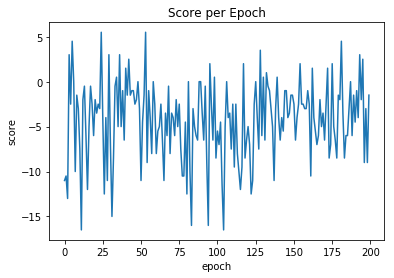

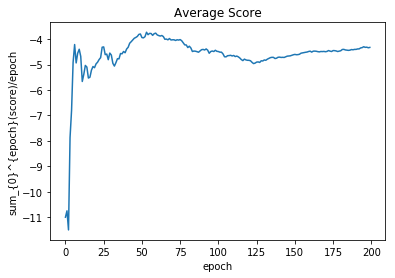

Final score: -4.3275


In [8]:
### ADDED
epochs_test = 200
###

# Initialize the game
env_random = Environment(grid_size=size, max_time=T, temperature=temperature)

# Initialize the agent!
agent_random = RandomAgent()

test(agent_random, env_random, epochs_test, prefix='random')

### MODIFIED
HTML(display_videos('random'+str(epochs_test)+'.mp4'))
###

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




__Answer 5__ Let $\pi$ be a policy.

1.

\begin{align*}
    Q^{\pi}(s,a) & := E[\sum_{t=0}^{\infty}\gamma^{t} r(S_{t},A_{t})|S_{0}=s, A_{0}=a, A_{t} = \pi(S_{t}), \forall t \ge 1] \\
                 & = r(s,a) + \gamma E[\sum_{t=1}^{\infty}\gamma^{t-1} r(S_{t},A_{t})|S_{0}=s, A_{0}=a] \\
                 & = r(s,a) + \gamma E_{(S^{'},A^{'})\sim f(.,.|s,a)}[E[\sum_{t=1}^{\infty}\gamma^{t-1} r(S_{t},A_{t})|S_{1}=S',A_{1}=A']|S_{0}=s, A_{0}=a] \\
                 &= r(s,a) + \gamma E_{(S^{'},A^{'})\sim f(.,.|s,a)}[Q^{\pi}(S^{'},A^{'})] \\
\end{align*}

Thanks to a conditional expectation trick (whose proof is below) and Markovian property

\begin{align*}
E_{X}[X] &= \int x f_{X}(x) dx \\
         &= \int x (\int f_{X}(x,y) dy) dx \\ 
         &= \int \int x f_{X}(x,y) dy dx \\
         &= \int \int x f_{X|Y=y}(x) f_{Y}(y) dx dy \\
         &= \int ( \int x f_{X|Y=y}(x) dx ) f_{Y}(y) dy \\
         &= \int ( E_{X|Y}[X|Y=y] ) f_{Y}(y) dy \\
         &= E_{Y}[ E_{X|Y}[X|Y] ]     
\end{align*}

2.

\begin{align*}
    Q^{\pi}(s,a) &= r(s,a) + \gamma E_{(S^{'},A^{'})\sim f(.,.|s,a)}[Q^{\pi}(S^{'},A^{'})] \\
                 &= r(s,a) + \gamma E_{S^{'}\sim p(.|s,a)}[Q^{\pi}(S^{'},\pi(S^{'}))] \\
                 &= r(s,a) + \gamma \sum_{s^{'}}p(s^{'}|s,a) Q^{\pi}(s^{'},\pi(s^{'}))
\end{align*}

by taking the $max$, we have :

\begin{align*}
    Q^{*}(s,a) &= r(s,a) + \gamma \max_{\pi} \sum_{s'}p(s^{'}|s,a) Q^{\pi}(s^{'},\pi(s^{'})) \\
               &= r(s,a) + \gamma \sum_{s^{'}}p(s^{'}|s,a) max_{\pi} Q^{\pi}(s^{'},\pi(s^{'})) \\
               &= r(s,a) + \gamma \sum_{s^{'}}p(s^{'}|s,a) Q^{*}(s^{'},\pi^{*}(s^{'})) \\
               &= r(s,a) + \gamma \sum_{s^{'}}p(s^{'}|s,a) max_{a^{'}}Q^{*}(s^{'},a^{'}) \\
               &= r(s,a) + \gamma E_{S^{'}\sim p(.|s,a)}[max_{a^{'}}Q^{*}(S^{'},a^{'})]
\end{align*}

3.

From the previous question we have the optimal Q-function :

\begin{align*}
    Q^{*}(s,a) &= r(s,a) + \gamma E_{S^{'}\sim p(.|s,a)}[\max_{a'}Q^{*}(S^{'},a')]
\end{align*}

this equation follows the Bellman Equation, and many RL algorithms (Value Iteration algorithm) lay on this, using Bellman equation as an iterative update :

\begin{align*}
    Q_{t+1}(s,a) &= r(s,a) + \gamma E_{S^{'}\sim p(.|s,a)}[\max_{a'}Q_{t}(S^{'},a')]
\end{align*}

and converge to the optimal Q-function $Q^{*}$.


recall that we want to find a Q-function $Q$ that is as much as possible near from the optimal Q-function $Q^{*}$.

For this, we parametrize $Q$ by $\theta$, that give us $Q_{\theta}$, and we want to find that $\theta$ that minimizes the following equation :

\begin{equation*}
    \mathcal{L}(\theta)= (Q^{*}(s,a)-Q_{\theta}(s,a))^{2}
\end{equation*}

But $Q^{*}$ is unknown, using the previous principle, we have to replace it by its one-step estimate $y_{t} = r(s,a) +\gamma E_{S^{'}\sim p(.|s,a)}[\max_{a'}Q_{\theta_{t}}(S',a')]$ called the target.

That give us the following equation :

\begin{equation*}
    \mathcal{L}(\theta_{t+1})=E_{\mathcal{D}}[(y_{t}-Q_{\theta_{t+1}}(s,a))^{2}]
\end{equation*}

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory)<self.max_memory:
            self.memory.append(m)
        else:
            self.memory.append(m)
            self.memory.pop(0)
            ### ALTERNATIVE
            #self.memory[randint(0,len(self.memory)-1)] = m
            ###

    def random_access(self):
        return self.memory[randint(0,len(self.memory)-1)]

***
The pipeline we will use for training is given below:

In [10]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    ### ADDED
    score_per_epoch = []
    average_score = []
    ###

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)
 
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        ### MODIFIED
        # Save as a mp4
        #if e % 10 == 0:
        #    env.draw(prefix+str(e))
        ###

        # Update stats
        score += win-lose
        
        ### ADDED
        score_per_epoch.append(win-lose)
        average_score.append(score/(1+e))
        ###

        ### MODIFIED
        #print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})".format(e+1, epoch, loss, win, lose, win-lose))
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epoch, loss, win, lose, win-lose))
        ###
        
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    
    ### ADDED
    env.draw(prefix+str(epoch))
    ###
    
    ### ADDED
    plt.figure()
    plt.plot(score_per_epoch)
    plt.title("Score per Epoch")
    plt.xlabel("epoch")
    plt.ylabel("score")
    
    plt.figure()
    plt.plot(average_score)
    plt.title("Average Score")
    plt.xlabel("epoch")
    plt.ylabel("sum_{0}^{epoch}(score)/epoch")
    plt.show()
    ###
    
    ### ADDED
    print('Final score: '+str(score/epoch))
    ###
    

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [11]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        ### ADDED
        Q_theta_s_a = self.model.predict(s.reshape(1, 5, 5, self.n_state)).ravel()
        a_star = np.argmax(Q_theta_s_a)
        return a_star
        ###

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            
            ######## FILL IN
            minibatch = self.memory.random_access()
            s, ns, a, r, game_over = minibatch
            input_states[i,:,:,:] = s
            ########
            
            ### MODIFIED
            #if game_over_:
            if game_over:
            ###
                ######## FILL IN
                target_q[i,a] = r
                ########
                
            else:
                ######## FILL IN
                Q_theta_ns_a = self.model.predict(ns.reshape(1, 5, 5, self.n_state)).ravel()
                target_q[i,a] = r + self.discount * np.max(Q_theta_ns_a)
                ########
                
        ######## FILL IN
        ########
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        l = self.model.train_on_batch(input_states, target_q)
        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        ####### FILL IN
        model = Sequential()
        model.add(Flatten(input_shape=(5, 5, self.n_state)))
        model.add(Dense(units=64, activation='relu'))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dense(units=4))
        #######
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

Epoch 001/500 | Loss 0.0002 | Win/lose count 04.5/04.0 (+00.5)
Epoch 002/500 | Loss 0.0002 | Win/lose count 03.0/11.0 (-08.0)
Epoch 003/500 | Loss 0.0020 | Win/lose count 04.5/02.0 (+02.5)
Epoch 004/500 | Loss 0.0047 | Win/lose count 04.5/09.0 (-04.5)
Epoch 005/500 | Loss 0.0017 | Win/lose count 06.5/10.0 (-03.5)
Epoch 006/500 | Loss 0.0008 | Win/lose count 09.5/12.0 (-02.5)
Epoch 007/500 | Loss 0.0004 | Win/lose count 05.5/09.0 (-03.5)
Epoch 008/500 | Loss 0.0014 | Win/lose count 04.5/14.0 (-09.5)
Epoch 009/500 | Loss 0.0008 | Win/lose count 09.0/09.0 (+00.0)
Epoch 010/500 | Loss 0.0019 | Win/lose count 07.0/09.0 (-02.0)
Epoch 011/500 | Loss 0.0002 | Win/lose count 08.0/05.0 (+03.0)
Epoch 012/500 | Loss 0.2223 | Win/lose count 03.5/04.0 (-00.5)
Epoch 013/500 | Loss 0.0001 | Win/lose count 03.5/10.0 (-06.5)
Epoch 014/500 | Loss 0.0006 | Win/lose count 08.0/08.0 (+00.0)
Epoch 015/500 | Loss 0.0682 | Win/lose count 04.0/09.0 (-05.0)
Epoch 016/500 | Loss 0.0002 | Win/lose count 07.0/08.0 

Epoch 132/500 | Loss 0.0036 | Win/lose count 06.0/03.0 (+03.0)
Epoch 133/500 | Loss 0.0148 | Win/lose count 06.5/07.0 (-00.5)
Epoch 134/500 | Loss 0.0003 | Win/lose count 04.0/00.0 (+04.0)
Epoch 135/500 | Loss 0.0308 | Win/lose count 04.0/02.0 (+02.0)
Epoch 136/500 | Loss 0.0005 | Win/lose count 07.0/06.0 (+01.0)
Epoch 137/500 | Loss 0.0000 | Win/lose count 09.0/10.0 (-01.0)
Epoch 138/500 | Loss 0.0062 | Win/lose count 07.5/06.0 (+01.5)
Epoch 139/500 | Loss 0.0005 | Win/lose count 02.0/01.0 (+01.0)
Epoch 140/500 | Loss 0.0020 | Win/lose count 06.0/03.0 (+03.0)
Epoch 141/500 | Loss 0.0003 | Win/lose count 03.5/05.0 (-01.5)
Epoch 142/500 | Loss 0.0001 | Win/lose count 07.5/07.0 (+00.5)
Epoch 143/500 | Loss 0.0000 | Win/lose count 12.0/05.0 (+07.0)
Epoch 144/500 | Loss 0.0005 | Win/lose count 08.0/10.0 (-02.0)
Epoch 145/500 | Loss 0.0000 | Win/lose count 16.5/09.0 (+07.5)
Epoch 146/500 | Loss 0.0004 | Win/lose count 10.5/05.0 (+05.5)
Epoch 147/500 | Loss 0.0081 | Win/lose count 03.0/08.0 

Epoch 263/500 | Loss 0.2501 | Win/lose count 10.5/08.0 (+02.5)
Epoch 264/500 | Loss 0.0001 | Win/lose count 06.5/09.0 (-02.5)
Epoch 265/500 | Loss 0.0001 | Win/lose count 08.0/06.0 (+02.0)
Epoch 266/500 | Loss 0.0471 | Win/lose count 08.5/12.0 (-03.5)
Epoch 267/500 | Loss 0.0001 | Win/lose count 19.5/05.0 (+14.5)
Epoch 268/500 | Loss 0.0012 | Win/lose count 07.0/07.0 (+00.0)
Epoch 269/500 | Loss 0.0037 | Win/lose count 04.5/06.0 (-01.5)
Epoch 270/500 | Loss 0.2002 | Win/lose count 19.5/09.0 (+10.5)
Epoch 271/500 | Loss 0.0420 | Win/lose count 13.5/09.0 (+04.5)
Epoch 272/500 | Loss 0.0043 | Win/lose count 09.0/10.0 (-01.0)
Epoch 273/500 | Loss 0.0080 | Win/lose count 15.0/12.0 (+03.0)
Epoch 274/500 | Loss 0.0001 | Win/lose count 05.5/05.0 (+00.5)
Epoch 275/500 | Loss 0.0005 | Win/lose count 06.5/01.0 (+05.5)
Epoch 276/500 | Loss 0.0281 | Win/lose count 06.5/14.0 (-07.5)
Epoch 277/500 | Loss 0.0050 | Win/lose count 04.5/02.0 (+02.5)
Epoch 278/500 | Loss 0.0089 | Win/lose count 02.0/04.0 

Epoch 394/500 | Loss 0.0000 | Win/lose count 09.0/06.0 (+03.0)
Epoch 395/500 | Loss 0.0001 | Win/lose count 10.0/01.0 (+09.0)
Epoch 396/500 | Loss 0.0000 | Win/lose count 11.0/02.0 (+09.0)
Epoch 397/500 | Loss 0.0000 | Win/lose count 11.5/03.0 (+08.5)
Epoch 398/500 | Loss 0.0000 | Win/lose count 08.0/05.0 (+03.0)
Epoch 399/500 | Loss 0.0027 | Win/lose count 09.5/08.0 (+01.5)
Epoch 400/500 | Loss 0.0000 | Win/lose count 05.5/08.0 (-02.5)
Epoch 401/500 | Loss 0.0003 | Win/lose count 07.0/07.0 (+00.0)
Epoch 402/500 | Loss 0.1083 | Win/lose count 12.5/04.0 (+08.5)
Epoch 403/500 | Loss 0.0000 | Win/lose count 08.5/02.0 (+06.5)
Epoch 404/500 | Loss 0.0000 | Win/lose count 09.5/05.0 (+04.5)
Epoch 405/500 | Loss 0.0000 | Win/lose count 06.5/03.0 (+03.5)
Epoch 406/500 | Loss 0.0005 | Win/lose count 08.0/01.0 (+07.0)
Epoch 407/500 | Loss 0.0015 | Win/lose count 04.5/03.0 (+01.5)
Epoch 408/500 | Loss 0.0017 | Win/lose count 13.5/09.0 (+04.5)
Epoch 409/500 | Loss 0.0000 | Win/lose count 09.5/04.0 

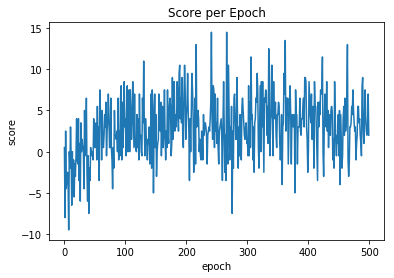

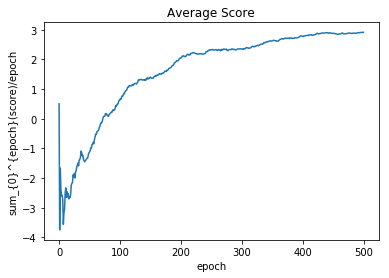

Final score: 2.912


In [12]:
### ADDED
epochs_train = 500
###

env_fc_train = Environment(grid_size=size, max_time=T, temperature=0.3)

### MODIFIED
#agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_fc_train = DQN_FC(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1)
###

train(agent_fc_train, env_fc_train, epochs_train, prefix='fc_train')

HTML(display_videos('fc_train'+str(epochs_train)+'.mp4'))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [13]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(80,(2,2),input_shape=(5,5,self.n_state),activation='relu'))
        model.add(Conv2D(40,(2,2),activation='relu'))
        model.add(Conv2D(20,(2,2),activation='relu'))
        model.add(Flatten())
        model.add(Dense(units=64, activation='relu'))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dense(units=4))
        ######
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

Epoch 001/500 | Loss 0.0054 | Win/lose count 06.0/05.0 (+01.0)
Epoch 002/500 | Loss 0.0007 | Win/lose count 05.0/07.0 (-02.0)
Epoch 003/500 | Loss 0.0001 | Win/lose count 05.0/08.0 (-03.0)
Epoch 004/500 | Loss 0.0001 | Win/lose count 03.5/05.0 (-01.5)
Epoch 005/500 | Loss 0.0033 | Win/lose count 04.5/05.0 (-00.5)
Epoch 006/500 | Loss 0.0001 | Win/lose count 07.5/04.0 (+03.5)
Epoch 007/500 | Loss 0.0015 | Win/lose count 03.0/09.0 (-06.0)
Epoch 008/500 | Loss 0.0017 | Win/lose count 01.0/06.0 (-05.0)
Epoch 009/500 | Loss 0.0842 | Win/lose count 03.5/05.0 (-01.5)
Epoch 010/500 | Loss 0.0001 | Win/lose count 05.0/06.0 (-01.0)
Epoch 011/500 | Loss 0.0010 | Win/lose count 03.0/03.0 (+00.0)
Epoch 012/500 | Loss 0.0001 | Win/lose count 01.0/02.0 (-01.0)
Epoch 013/500 | Loss 0.0005 | Win/lose count 06.0/07.0 (-01.0)
Epoch 014/500 | Loss 0.0002 | Win/lose count 07.0/02.0 (+05.0)
Epoch 015/500 | Loss 0.0014 | Win/lose count 02.5/08.0 (-05.5)
Epoch 016/500 | Loss 0.0001 | Win/lose count 08.0/07.0 

Epoch 132/500 | Loss 0.0014 | Win/lose count 12.0/07.0 (+05.0)
Epoch 133/500 | Loss 0.0024 | Win/lose count 17.5/11.0 (+06.5)
Epoch 134/500 | Loss 0.0103 | Win/lose count 10.5/08.0 (+02.5)
Epoch 135/500 | Loss 0.0170 | Win/lose count 04.0/03.0 (+01.0)
Epoch 136/500 | Loss 0.0209 | Win/lose count 07.5/01.0 (+06.5)
Epoch 137/500 | Loss 0.0011 | Win/lose count 11.0/10.0 (+01.0)
Epoch 138/500 | Loss 0.0011 | Win/lose count 10.5/04.0 (+06.5)
Epoch 139/500 | Loss 0.0008 | Win/lose count 11.0/07.0 (+04.0)
Epoch 140/500 | Loss 0.0007 | Win/lose count 04.0/07.0 (-03.0)
Epoch 141/500 | Loss 0.0007 | Win/lose count 09.0/07.0 (+02.0)
Epoch 142/500 | Loss 0.0127 | Win/lose count 18.0/07.0 (+11.0)
Epoch 143/500 | Loss 0.0222 | Win/lose count 15.5/10.0 (+05.5)
Epoch 144/500 | Loss 0.0017 | Win/lose count 14.0/07.0 (+07.0)
Epoch 145/500 | Loss 0.0015 | Win/lose count 11.0/06.0 (+05.0)
Epoch 146/500 | Loss 0.0010 | Win/lose count 17.5/08.0 (+09.5)
Epoch 147/500 | Loss 0.0010 | Win/lose count 11.5/04.0 

Epoch 263/500 | Loss 0.0028 | Win/lose count 25.0/08.0 (+17.0)
Epoch 264/500 | Loss 0.0893 | Win/lose count 19.5/05.0 (+14.5)
Epoch 265/500 | Loss 0.0382 | Win/lose count 17.5/06.0 (+11.5)
Epoch 266/500 | Loss 0.0125 | Win/lose count 18.0/10.0 (+08.0)
Epoch 267/500 | Loss 0.0477 | Win/lose count 21.5/10.0 (+11.5)
Epoch 268/500 | Loss 0.1441 | Win/lose count 11.0/01.0 (+10.0)
Epoch 269/500 | Loss 0.0008 | Win/lose count 25.0/06.0 (+19.0)
Epoch 270/500 | Loss 0.0190 | Win/lose count 11.5/05.0 (+06.5)
Epoch 271/500 | Loss 0.0032 | Win/lose count 24.5/11.0 (+13.5)
Epoch 272/500 | Loss 0.0523 | Win/lose count 20.5/08.0 (+12.5)
Epoch 273/500 | Loss 0.0323 | Win/lose count 20.0/09.0 (+11.0)
Epoch 274/500 | Loss 0.1236 | Win/lose count 11.0/07.0 (+04.0)
Epoch 275/500 | Loss 0.0013 | Win/lose count 23.0/07.0 (+16.0)
Epoch 276/500 | Loss 0.0299 | Win/lose count 23.5/10.0 (+13.5)
Epoch 277/500 | Loss 0.2059 | Win/lose count 21.0/06.0 (+15.0)
Epoch 278/500 | Loss 0.0038 | Win/lose count 27.0/07.0 

Epoch 394/500 | Loss 0.0029 | Win/lose count 18.5/11.0 (+07.5)
Epoch 395/500 | Loss 0.0085 | Win/lose count 24.0/12.0 (+12.0)
Epoch 396/500 | Loss 0.0226 | Win/lose count 24.0/08.0 (+16.0)
Epoch 397/500 | Loss 0.1332 | Win/lose count 25.5/10.0 (+15.5)
Epoch 398/500 | Loss 0.1013 | Win/lose count 17.0/08.0 (+09.0)
Epoch 399/500 | Loss 0.0393 | Win/lose count 25.0/05.0 (+20.0)
Epoch 400/500 | Loss 0.0001 | Win/lose count 17.0/08.0 (+09.0)
Epoch 401/500 | Loss 0.0401 | Win/lose count 20.5/05.0 (+15.5)
Epoch 402/500 | Loss 0.0016 | Win/lose count 23.5/03.0 (+20.5)
Epoch 403/500 | Loss 0.0237 | Win/lose count 23.5/05.0 (+18.5)
Epoch 404/500 | Loss 0.0146 | Win/lose count 12.0/14.0 (-02.0)
Epoch 405/500 | Loss 0.0010 | Win/lose count 16.0/15.0 (+01.0)
Epoch 406/500 | Loss 0.0050 | Win/lose count 28.5/08.0 (+20.5)
Epoch 407/500 | Loss 0.0183 | Win/lose count 07.5/01.0 (+06.5)
Epoch 408/500 | Loss 0.0005 | Win/lose count 25.0/07.0 (+18.0)
Epoch 409/500 | Loss 0.1231 | Win/lose count 23.0/07.0 

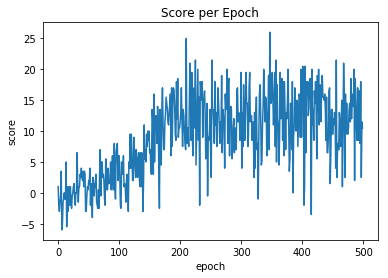

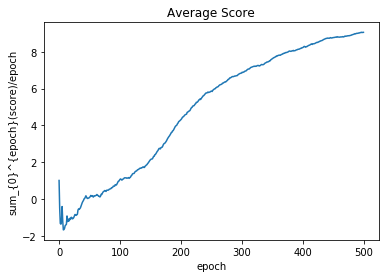

Final score: 9.053


In [14]:
### ADDED
epochs_train = 500
###

env_cnn_train = Environment(grid_size=size, max_time=T, temperature=0.3)

### MODIFIED
#agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn_train = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1)
###

train(agent_cnn_train, env_cnn_train, epochs_train, prefix='cnn_train')

HTML(display_videos('cnn_train'+str(epochs_train)+'.mp4'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [15]:
### ADDED
epochs_test = 200
###

env_test = Environment(grid_size=size, max_time=T, temperature=0.3)

Test of the FC
Epoch 001/200 | Loss ------ | Win/lose count 06.5/06.0 (+00.5)
Epoch 002/200 | Loss ------ | Win/lose count 04.5/03.0 (+01.5)
Epoch 003/200 | Loss ------ | Win/lose count 06.0/07.0 (-01.0)
Epoch 004/200 | Loss ------ | Win/lose count 05.0/02.0 (+03.0)
Epoch 005/200 | Loss ------ | Win/lose count 05.5/03.0 (+02.5)
Epoch 006/200 | Loss ------ | Win/lose count 12.5/07.0 (+05.5)
Epoch 007/200 | Loss ------ | Win/lose count 09.5/10.0 (-00.5)
Epoch 008/200 | Loss ------ | Win/lose count 02.0/04.0 (-02.0)
Epoch 009/200 | Loss ------ | Win/lose count 08.0/03.0 (+05.0)
Epoch 010/200 | Loss ------ | Win/lose count 07.5/04.0 (+03.5)
Epoch 011/200 | Loss ------ | Win/lose count 13.0/07.0 (+06.0)
Epoch 012/200 | Loss ------ | Win/lose count 08.0/03.0 (+05.0)
Epoch 013/200 | Loss ------ | Win/lose count 06.0/02.0 (+04.0)
Epoch 014/200 | Loss ------ | Win/lose count 01.0/03.0 (-02.0)
Epoch 015/200 | Loss ------ | Win/lose count 07.0/02.0 (+05.0)
Epoch 016/200 | Loss ------ | Win/lose c

Epoch 131/200 | Loss ------ | Win/lose count 07.0/06.0 (+01.0)
Epoch 132/200 | Loss ------ | Win/lose count 06.0/06.0 (+00.0)
Epoch 133/200 | Loss ------ | Win/lose count 03.0/03.0 (+00.0)
Epoch 134/200 | Loss ------ | Win/lose count 08.0/07.0 (+01.0)
Epoch 135/200 | Loss ------ | Win/lose count 06.0/07.0 (-01.0)
Epoch 136/200 | Loss ------ | Win/lose count 06.0/04.0 (+02.0)
Epoch 137/200 | Loss ------ | Win/lose count 05.0/04.0 (+01.0)
Epoch 138/200 | Loss ------ | Win/lose count 14.0/04.0 (+10.0)
Epoch 139/200 | Loss ------ | Win/lose count 12.0/05.0 (+07.0)
Epoch 140/200 | Loss ------ | Win/lose count 03.0/04.0 (-01.0)
Epoch 141/200 | Loss ------ | Win/lose count 08.5/03.0 (+05.5)
Epoch 142/200 | Loss ------ | Win/lose count 10.0/07.0 (+03.0)
Epoch 143/200 | Loss ------ | Win/lose count 06.5/02.0 (+04.5)
Epoch 144/200 | Loss ------ | Win/lose count 11.0/01.0 (+10.0)
Epoch 145/200 | Loss ------ | Win/lose count 01.0/01.0 (+00.0)
Epoch 146/200 | Loss ------ | Win/lose count 04.5/04.0 

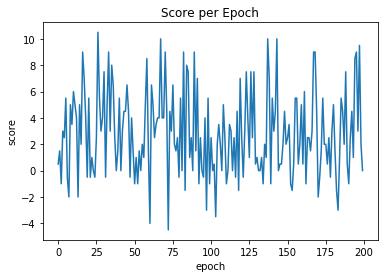

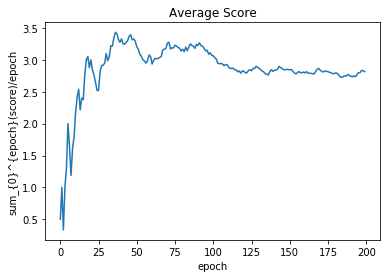

Final score: 2.815


In [16]:
### MODIFIED
#agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_fc_test = DQN_FC(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1)
#agent_cnn.load(name_weights='fc_trainmodel.h5', name_model='fc_trainmodel.json')
agent_fc_test.load(name_weights='fc_trainmodel.h5', name_model='fc_trainmodel.json')
###

print('Test of the FC')
test(agent_fc_test, env_test, epochs_test, prefix='fc_test')

HTML(display_videos('fc_test'+str(epochs_test)+'.mp4'))

Test of the CNN
Epoch 001/200 | Loss ------ | Win/lose count 22.5/07.0 (+15.5)
Epoch 002/200 | Loss ------ | Win/lose count 15.0/05.0 (+10.0)
Epoch 003/200 | Loss ------ | Win/lose count 18.0/07.0 (+11.0)
Epoch 004/200 | Loss ------ | Win/lose count 14.5/01.0 (+13.5)
Epoch 005/200 | Loss ------ | Win/lose count 22.0/07.0 (+15.0)
Epoch 006/200 | Loss ------ | Win/lose count 22.0/09.0 (+13.0)
Epoch 007/200 | Loss ------ | Win/lose count 13.5/00.0 (+13.5)
Epoch 008/200 | Loss ------ | Win/lose count 10.5/02.0 (+08.5)
Epoch 009/200 | Loss ------ | Win/lose count 12.0/03.0 (+09.0)
Epoch 010/200 | Loss ------ | Win/lose count 25.5/10.0 (+15.5)
Epoch 011/200 | Loss ------ | Win/lose count 07.5/04.0 (+03.5)
Epoch 012/200 | Loss ------ | Win/lose count 13.0/06.0 (+07.0)
Epoch 013/200 | Loss ------ | Win/lose count 18.0/08.0 (+10.0)
Epoch 014/200 | Loss ------ | Win/lose count 09.5/05.0 (+04.5)
Epoch 015/200 | Loss ------ | Win/lose count 16.5/04.0 (+12.5)
Epoch 016/200 | Loss ------ | Win/lose 

Epoch 131/200 | Loss ------ | Win/lose count 17.5/05.0 (+12.5)
Epoch 132/200 | Loss ------ | Win/lose count 24.0/10.0 (+14.0)
Epoch 133/200 | Loss ------ | Win/lose count 18.5/06.0 (+12.5)
Epoch 134/200 | Loss ------ | Win/lose count 19.0/06.0 (+13.0)
Epoch 135/200 | Loss ------ | Win/lose count 03.0/02.0 (+01.0)
Epoch 136/200 | Loss ------ | Win/lose count 12.5/01.0 (+11.5)
Epoch 137/200 | Loss ------ | Win/lose count 20.0/04.0 (+16.0)
Epoch 138/200 | Loss ------ | Win/lose count 24.5/03.0 (+21.5)
Epoch 139/200 | Loss ------ | Win/lose count 14.5/06.0 (+08.5)
Epoch 140/200 | Loss ------ | Win/lose count 20.0/06.0 (+14.0)
Epoch 141/200 | Loss ------ | Win/lose count 14.5/06.0 (+08.5)
Epoch 142/200 | Loss ------ | Win/lose count 18.0/05.0 (+13.0)
Epoch 143/200 | Loss ------ | Win/lose count 07.5/02.0 (+05.5)
Epoch 144/200 | Loss ------ | Win/lose count 23.5/05.0 (+18.5)
Epoch 145/200 | Loss ------ | Win/lose count 25.0/06.0 (+19.0)
Epoch 146/200 | Loss ------ | Win/lose count 10.5/04.0 

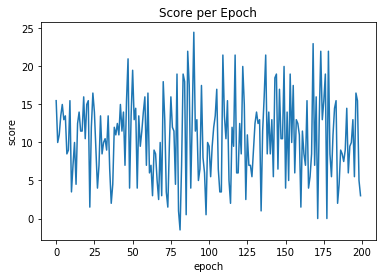

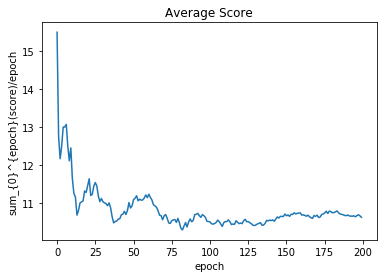

Final score: 10.6225


In [17]:
### MODIFIED
#agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn_test = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1)
###
agent_cnn_test.load(name_weights='cnn_trainmodel.h5', name_model='cnn_trainmodel.json')

print('Test of the CNN')
test(agent_cnn_test, env_test, epochs_test, prefix='cnn_test')

HTML(display_videos('cnn_test'+str(epochs_test)+'.mp4'))

__Answer 9__

We observe that DQN algorithm using CNN performs better than the one using only fully connected layers.

Futhermore, when we increase the temperature, more bonus (cheese) appear on the game grid, so the agent seems less often blocked on a part of the grid.


***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [18]:
def train_explore(agent, env, epoch, start_epsilon, end_epsilon, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    ### ADDED
    agent.set_epsilon(start_epsilon)
    ###
    
    ### ADDED
    score_per_epoch = []
    average_score = []
    ###

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        
        ### ADDED
        epsilon = ((end_epsilon-start_epsilon)/(epoch-1))*e + start_epsilon
        agent.set_epsilon(epsilon)
        ###

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            ### MODIFIED
            #state, reward, game_over = env.act(action)
            ## use those samples of code:
            #In train explore:
            state, reward, game_over = env.act(action, train=True)
            ###

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        ### MODIFIED
        # Save as a mp4
        #if e % 10 == 0:
        #    env.draw(prefix+str(e))
        ###

        # Update stats
        score += win-lose
        
        ### MODIFIED
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epoch, loss, win, lose, win-lose))
        ###
        
        ### ADDED
        score_per_epoch.append(win-lose)
        average_score.append(score/(1+e))
        ###
        
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    
    ### ADDED
    env.draw(prefix+str(epoch))
    ###
    
    ### ADDED
    plt.figure()
    plt.plot(score_per_epoch)
    plt.title("Score per Epoch")
    plt.xlabel("epoch")
    plt.ylabel("score")
    
    plt.figure()
    plt.plot(average_score)
    plt.title("Average Score")
    plt.xlabel("epoch")
    plt.ylabel("sum_{0}^{epoch}(score)/epoch")
    plt.show()
    ###
    
    ### ADDED
    print('Final score: '+str(score/epoch))
    ###
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size,grid_size))
        
        # coordinate of the rat
        self.x = 0
        self.y = 1
        
        # self time
        self.t = 0
        
        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board > 0,0] = 256
        b[self.board < 0,2] = 256
        b[self.x,self.y,:] = 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b

    ### MODIFIED
    #def act(self, action):
    def act(self, action, train=False):
    ###
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))
        
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        ### MODIFIED
        #self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        ###

        self.position[self.x, self.y] = 1
        
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')
        self.t = self.t + 1
        
        ### MODIFIED
        ## In Environment exploring:
        # You will have to change n_state to 3 because you will use one more layer!
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        reward = reward + self.board[self.x, self.y]
        ###
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        ### MODIFIED
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        ###
        
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        
        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1,self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0
        
        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        ### MODIFIED
        #self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        ###
        
        self.board[self.x,self.y] = 0
        self.t = 0

        ### MODIFIED
        #state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1), self.position.reshape(self.grid_size, self.grid_size,1)), axis=2)
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        ###
        
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        return state

Epoch 001/500 | Loss 0.0763 | Win/lose count 11.5/25.8 (-14.3)
Epoch 002/500 | Loss 0.0758 | Win/lose count 09.0/27.6 (-18.6)
Epoch 003/500 | Loss 0.2292 | Win/lose count 09.3/21.3 (-12.0)
Epoch 004/500 | Loss 0.0009 | Win/lose count 09.1/26.8 (-17.7)
Epoch 005/500 | Loss 0.0018 | Win/lose count 10.5/32.9 (-22.4)
Epoch 006/500 | Loss 0.0024 | Win/lose count 05.8/31.6 (-25.8)
Epoch 007/500 | Loss 0.0012 | Win/lose count 04.8/32.5 (-27.7)
Epoch 008/500 | Loss 0.0041 | Win/lose count 09.0/31.7 (-22.7)
Epoch 009/500 | Loss 0.0011 | Win/lose count 10.4/33.5 (-23.1)
Epoch 010/500 | Loss 0.0042 | Win/lose count 09.3/27.8 (-18.5)
Epoch 011/500 | Loss 0.0020 | Win/lose count 06.8/28.4 (-21.6)
Epoch 012/500 | Loss 0.0021 | Win/lose count 13.3/26.7 (-13.4)
Epoch 013/500 | Loss 0.0406 | Win/lose count 06.0/24.6 (-18.6)
Epoch 014/500 | Loss 0.2449 | Win/lose count 09.2/25.8 (-16.6)
Epoch 015/500 | Loss 0.0017 | Win/lose count 10.8/31.4 (-20.6)
Epoch 016/500 | Loss 0.0022 | Win/lose count 07.2/23.3 

Epoch 132/500 | Loss 0.0095 | Win/lose count 18.0/24.6 (-06.6)
Epoch 133/500 | Loss 0.0062 | Win/lose count 16.4/30.0 (-13.6)
Epoch 134/500 | Loss 0.0027 | Win/lose count 14.4/23.5 (-09.1)
Epoch 135/500 | Loss 0.0023 | Win/lose count 14.0/22.6 (-08.6)
Epoch 136/500 | Loss 0.0030 | Win/lose count 18.8/26.4 (-07.6)
Epoch 137/500 | Loss 0.0012 | Win/lose count 16.0/25.1 (-09.1)
Epoch 138/500 | Loss 0.0402 | Win/lose count 12.4/19.0 (-06.6)
Epoch 139/500 | Loss 0.0074 | Win/lose count 11.6/25.2 (-13.6)
Epoch 140/500 | Loss 0.0032 | Win/lose count 15.6/22.2 (-06.6)
Epoch 141/500 | Loss 0.0415 | Win/lose count 21.6/20.7 (+00.9)
Epoch 142/500 | Loss 0.0014 | Win/lose count 19.2/22.3 (-03.1)
Epoch 143/500 | Loss 0.0066 | Win/lose count 14.8/19.4 (-04.6)
Epoch 144/500 | Loss 0.0036 | Win/lose count 13.6/24.7 (-11.1)
Epoch 145/500 | Loss 0.0054 | Win/lose count 16.8/25.9 (-09.1)
Epoch 146/500 | Loss 0.0066 | Win/lose count 21.2/22.8 (-01.6)
Epoch 147/500 | Loss 0.0010 | Win/lose count 18.4/24.5 

Epoch 263/500 | Loss 0.0037 | Win/lose count 19.2/23.3 (-04.1)
Epoch 264/500 | Loss 0.0661 | Win/lose count 20.0/21.1 (-01.1)
Epoch 265/500 | Loss 0.2292 | Win/lose count 12.8/21.9 (-09.1)
Epoch 266/500 | Loss 0.0047 | Win/lose count 14.0/19.6 (-05.6)
Epoch 267/500 | Loss 0.0037 | Win/lose count 16.0/20.1 (-04.1)
Epoch 268/500 | Loss 0.0011 | Win/lose count 15.2/16.3 (-01.1)
Epoch 269/500 | Loss 0.0015 | Win/lose count 11.6/23.2 (-11.6)
Epoch 270/500 | Loss 0.0032 | Win/lose count 11.2/28.3 (-17.1)
Epoch 271/500 | Loss 0.1347 | Win/lose count 18.0/27.6 (-09.6)
Epoch 272/500 | Loss 0.0030 | Win/lose count 13.6/21.7 (-08.1)
Epoch 273/500 | Loss 0.0035 | Win/lose count 16.0/28.1 (-12.1)
Epoch 274/500 | Loss 0.0893 | Win/lose count 16.0/21.1 (-05.1)
Epoch 275/500 | Loss 0.0171 | Win/lose count 05.6/21.7 (-16.1)
Epoch 276/500 | Loss 0.0035 | Win/lose count 19.2/23.3 (-04.1)
Epoch 277/500 | Loss 0.0040 | Win/lose count 18.4/23.5 (-05.1)
Epoch 278/500 | Loss 0.0155 | Win/lose count 18.0/27.6 

Epoch 394/500 | Loss 0.0323 | Win/lose count 18.0/20.6 (-02.6)
Epoch 395/500 | Loss 0.0413 | Win/lose count 19.6/27.2 (-07.6)
Epoch 396/500 | Loss 0.1611 | Win/lose count 10.0/22.6 (-12.6)
Epoch 397/500 | Loss 0.0188 | Win/lose count 16.4/20.0 (-03.6)
Epoch 398/500 | Loss 0.0044 | Win/lose count 10.8/19.4 (-08.6)
Epoch 399/500 | Loss 0.0028 | Win/lose count 20.0/20.1 (-00.1)
Epoch 400/500 | Loss 0.0516 | Win/lose count 06.0/21.6 (-15.6)
Epoch 401/500 | Loss 0.0028 | Win/lose count 12.8/18.9 (-06.1)
Epoch 402/500 | Loss 0.0029 | Win/lose count 20.0/23.1 (-03.1)
Epoch 403/500 | Loss 0.0034 | Win/lose count 20.4/20.0 (+00.4)
Epoch 404/500 | Loss 0.0024 | Win/lose count 21.6/19.7 (+01.9)
Epoch 405/500 | Loss 0.0630 | Win/lose count 16.8/18.9 (-02.1)
Epoch 406/500 | Loss 0.0088 | Win/lose count 13.2/21.8 (-08.6)
Epoch 407/500 | Loss 0.0007 | Win/lose count 15.2/19.3 (-04.1)
Epoch 408/500 | Loss 0.0024 | Win/lose count 14.8/17.4 (-02.6)
Epoch 409/500 | Loss 0.0019 | Win/lose count 12.8/20.9 

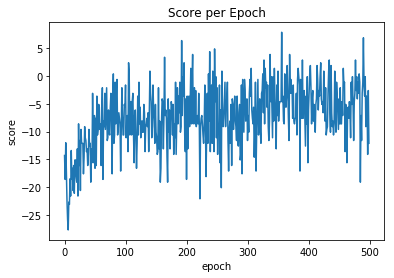

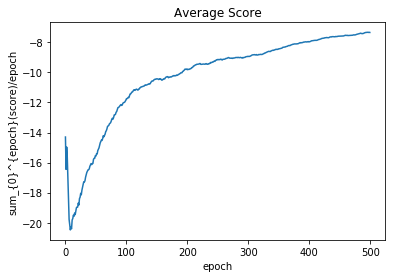

Final score: -7.34519999999998


In [19]:
### ADDED
epochs_train = 500
###

### ADDED
# epsilon will decrease linearly from "start_epsilon" to "end_epsilon" epoch after epoch.
start_epsilon = 0.2
end_epsilon = 0.01
###

# Training
env_explore_train = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)

### MODIFIED
#agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32, n_state=3)
agent_explore_train = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
###

train_explore(agent_explore_train, env_explore_train, epochs_train, start_epsilon, end_epsilon, prefix='cnn_train_explore')

### MODIFIED
HTML(display_videos('cnn_train_explore'+str(epochs_train)+'.mp4'))
###


Epoch 001/200 | Loss ------ | Win/lose count 19.0/14.0 (+05.0)
Epoch 002/200 | Loss ------ | Win/lose count 21.0/05.0 (+16.0)
Epoch 003/200 | Loss ------ | Win/lose count 15.0/09.0 (+06.0)
Epoch 004/200 | Loss ------ | Win/lose count 19.5/03.0 (+16.5)
Epoch 005/200 | Loss ------ | Win/lose count 16.0/08.0 (+08.0)
Epoch 006/200 | Loss ------ | Win/lose count 22.0/14.0 (+08.0)
Epoch 007/200 | Loss ------ | Win/lose count 25.0/16.0 (+09.0)
Epoch 008/200 | Loss ------ | Win/lose count 17.0/08.0 (+09.0)
Epoch 009/200 | Loss ------ | Win/lose count 18.0/05.0 (+13.0)
Epoch 010/200 | Loss ------ | Win/lose count 13.0/03.0 (+10.0)
Epoch 011/200 | Loss ------ | Win/lose count 22.0/08.0 (+14.0)
Epoch 012/200 | Loss ------ | Win/lose count 18.5/08.0 (+10.5)
Epoch 013/200 | Loss ------ | Win/lose count 22.5/11.0 (+11.5)
Epoch 014/200 | Loss ------ | Win/lose count 24.5/12.0 (+12.5)
Epoch 015/200 | Loss ------ | Win/lose count 25.0/10.0 (+15.0)
Epoch 016/200 | Loss ------ | Win/lose count 19.0/08.0 

Epoch 132/200 | Loss ------ | Win/lose count 16.5/10.0 (+06.5)
Epoch 133/200 | Loss ------ | Win/lose count 17.5/10.0 (+07.5)
Epoch 134/200 | Loss ------ | Win/lose count 22.0/12.0 (+10.0)
Epoch 135/200 | Loss ------ | Win/lose count 23.5/05.0 (+18.5)
Epoch 136/200 | Loss ------ | Win/lose count 12.5/08.0 (+04.5)
Epoch 137/200 | Loss ------ | Win/lose count 16.0/07.0 (+09.0)
Epoch 138/200 | Loss ------ | Win/lose count 12.0/05.0 (+07.0)
Epoch 139/200 | Loss ------ | Win/lose count 23.0/02.0 (+21.0)
Epoch 140/200 | Loss ------ | Win/lose count 16.5/07.0 (+09.5)
Epoch 141/200 | Loss ------ | Win/lose count 20.0/11.0 (+09.0)
Epoch 142/200 | Loss ------ | Win/lose count 27.0/06.0 (+21.0)
Epoch 143/200 | Loss ------ | Win/lose count 22.0/05.0 (+17.0)
Epoch 144/200 | Loss ------ | Win/lose count 26.5/05.0 (+21.5)
Epoch 145/200 | Loss ------ | Win/lose count 22.5/11.0 (+11.5)
Epoch 146/200 | Loss ------ | Win/lose count 16.5/07.0 (+09.5)
Epoch 147/200 | Loss ------ | Win/lose count 27.0/13.0 

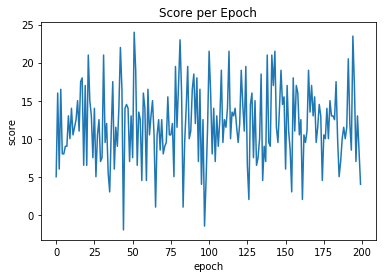

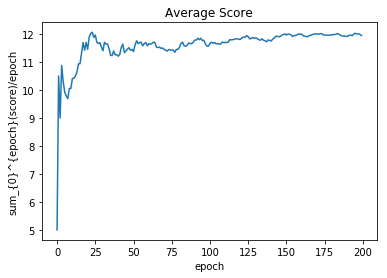

Final score: 11.9475


In [20]:
### ADDED
epochs_test = 200
###

### ADDED
env_explore_test = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent_explore_test = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
agent_explore_test.load(name_weights='cnn_train_exploremodel.h5', name_model='cnn_train_exploremodel.json')
###

# Evaluation
test(agent_explore_test, env_explore_test, epochs_test, prefix='cnn_test_explore')

### MODIFIED
HTML(display_videos('cnn_test_explore'+str(epochs_test)+'.mp4'))
###

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

The "mimick agent" imitates the expert by doing the same action as the expert does.

In [21]:
def train_mimick(agent, expert, env, epoch, prefix=''):
    score = 0
    loss = 0
    
    score_per_epoch = []
    average_score = []

    for e in range(epoch):
        state = env.reset()
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            ### MODIFIED
            ### we act here as the expert
            # action = agent.act(state)
            action = expert.act(state)
            ###

            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        ### MODIFIED
        #if e % 10 == 0:
        #    env.draw(prefix+str(e))
        ###
        
        score += win-lose
        
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epoch, loss, win, lose, win-lose))
        
        score_per_epoch.append(win-lose)
        average_score.append(score/(1+e))
        
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    
    env.draw(prefix+str(epoch))
    
    plt.figure()
    plt.plot(score_per_epoch)
    plt.title("Score per Epoch")
    plt.xlabel("epoch")
    plt.ylabel("score")
    
    plt.figure()
    plt.plot(average_score)
    plt.title("Average Score")
    plt.xlabel("epoch")
    plt.ylabel("sum_{0}^{epoch}(score)/epoch")
    plt.show()
    
    print('Final score: '+str(score/epoch))

Epoch 001/500 | Loss 0.0019 | Win/lose count 23.0/17.3 (+05.7)
Epoch 002/500 | Loss 0.0031 | Win/lose count 04.6/22.7 (-18.1)
Epoch 003/500 | Loss 0.0018 | Win/lose count 16.0/20.8 (-04.8)
Epoch 004/500 | Loss 0.0036 | Win/lose count 20.0/22.4 (-02.4)
Epoch 005/500 | Loss 0.0033 | Win/lose count 22.7/25.8 (-03.1)
Epoch 006/500 | Loss 0.0014 | Win/lose count 14.5/22.4 (-07.9)
Epoch 007/500 | Loss 0.0254 | Win/lose count 20.9/27.9 (-07.0)
Epoch 008/500 | Loss 0.0527 | Win/lose count 18.8/25.4 (-06.6)
Epoch 009/500 | Loss 0.0014 | Win/lose count 20.0/26.0 (-06.0)
Epoch 010/500 | Loss 0.0037 | Win/lose count 19.6/24.2 (-04.6)
Epoch 011/500 | Loss 0.0011 | Win/lose count 16.9/21.8 (-04.9)
Epoch 012/500 | Loss 0.0042 | Win/lose count 07.2/22.3 (-15.1)
Epoch 013/500 | Loss 0.0018 | Win/lose count 17.2/24.8 (-07.6)
Epoch 014/500 | Loss 0.0023 | Win/lose count 20.4/25.0 (-04.6)
Epoch 015/500 | Loss 0.0039 | Win/lose count 19.6/24.2 (-04.6)
Epoch 016/500 | Loss 0.0033 | Win/lose count 10.8/27.4 

Epoch 132/500 | Loss 0.3370 | Win/lose count 20.8/22.9 (-02.1)
Epoch 133/500 | Loss 0.0006 | Win/lose count 16.4/24.0 (-07.6)
Epoch 134/500 | Loss 0.0086 | Win/lose count 16.0/31.1 (-15.1)
Epoch 135/500 | Loss 0.0007 | Win/lose count 18.4/22.5 (-04.1)
Epoch 136/500 | Loss 0.0050 | Win/lose count 13.2/21.8 (-08.6)
Epoch 137/500 | Loss 0.0010 | Win/lose count 20.0/22.1 (-02.1)
Epoch 138/500 | Loss 0.0049 | Win/lose count 17.2/31.8 (-14.6)
Epoch 139/500 | Loss 0.0056 | Win/lose count 19.2/29.3 (-10.1)
Epoch 140/500 | Loss 0.0021 | Win/lose count 16.4/18.0 (-01.6)
Epoch 141/500 | Loss 0.0157 | Win/lose count 16.0/28.1 (-12.1)
Epoch 142/500 | Loss 0.0085 | Win/lose count 18.8/26.4 (-07.6)
Epoch 143/500 | Loss 0.0059 | Win/lose count 17.2/26.8 (-09.6)
Epoch 144/500 | Loss 0.0524 | Win/lose count 18.8/26.4 (-07.6)
Epoch 145/500 | Loss 0.0013 | Win/lose count 16.4/27.0 (-10.6)
Epoch 146/500 | Loss 0.0044 | Win/lose count 18.0/22.6 (-04.6)
Epoch 147/500 | Loss 0.0029 | Win/lose count 16.4/21.0 

Epoch 263/500 | Loss 0.0024 | Win/lose count 18.8/28.4 (-09.6)
Epoch 264/500 | Loss 0.0075 | Win/lose count 21.6/26.7 (-05.1)
Epoch 265/500 | Loss 0.0017 | Win/lose count 18.0/23.6 (-05.6)
Epoch 266/500 | Loss 0.0072 | Win/lose count 17.6/23.7 (-06.1)
Epoch 267/500 | Loss 0.0068 | Win/lose count 18.4/23.5 (-05.1)
Epoch 268/500 | Loss 0.0354 | Win/lose count 18.4/29.5 (-11.1)
Epoch 269/500 | Loss 0.0712 | Win/lose count 04.0/23.1 (-19.1)
Epoch 270/500 | Loss 0.0103 | Win/lose count 12.8/22.9 (-10.1)
Epoch 271/500 | Loss 0.0057 | Win/lose count 22.4/26.5 (-04.1)
Epoch 272/500 | Loss 0.0022 | Win/lose count 12.4/29.0 (-16.6)
Epoch 273/500 | Loss 0.0019 | Win/lose count 15.2/28.3 (-13.1)
Epoch 274/500 | Loss 0.0309 | Win/lose count 22.8/28.4 (-05.6)
Epoch 275/500 | Loss 0.0006 | Win/lose count 22.8/25.4 (-02.6)
Epoch 276/500 | Loss 0.0008 | Win/lose count 16.4/26.0 (-09.6)
Epoch 277/500 | Loss 0.0483 | Win/lose count 19.2/19.3 (-00.1)
Epoch 278/500 | Loss 0.0061 | Win/lose count 11.2/24.3 

Epoch 394/500 | Loss 0.0047 | Win/lose count 08.4/20.0 (-11.6)
Epoch 395/500 | Loss 0.0019 | Win/lose count 15.2/23.3 (-08.1)
Epoch 396/500 | Loss 0.0022 | Win/lose count 06.4/22.5 (-16.1)
Epoch 397/500 | Loss 0.0015 | Win/lose count 18.4/24.5 (-06.1)
Epoch 398/500 | Loss 0.0005 | Win/lose count 14.4/28.5 (-14.1)
Epoch 399/500 | Loss 0.0427 | Win/lose count 13.2/24.8 (-11.6)
Epoch 400/500 | Loss 0.0035 | Win/lose count 17.2/21.8 (-04.6)
Epoch 401/500 | Loss 0.0012 | Win/lose count 16.0/26.1 (-10.1)
Epoch 402/500 | Loss 0.1779 | Win/lose count 12.0/24.1 (-12.1)
Epoch 403/500 | Loss 0.0125 | Win/lose count 17.6/28.7 (-11.1)
Epoch 404/500 | Loss 0.0030 | Win/lose count 14.4/27.5 (-13.1)
Epoch 405/500 | Loss 0.0374 | Win/lose count 12.8/24.9 (-12.1)
Epoch 406/500 | Loss 0.0010 | Win/lose count 20.0/31.1 (-11.1)
Epoch 407/500 | Loss 0.0025 | Win/lose count 19.2/24.3 (-05.1)
Epoch 408/500 | Loss 0.0022 | Win/lose count 16.4/25.0 (-08.6)
Epoch 409/500 | Loss 0.0032 | Win/lose count 16.0/23.1 

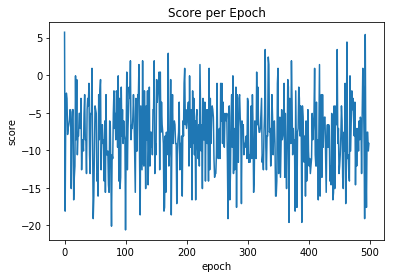

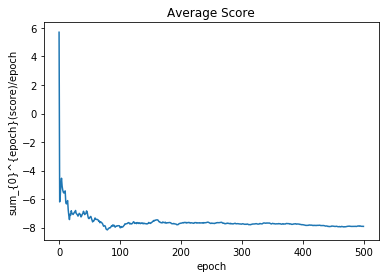

Final score: -7.9152000000000005


In [22]:
epochs_train = 500

env_mimick_train = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)

# we define the expert
expert = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
expert.load(name_weights='cnn_train_exploremodel.h5', name_model='cnn_train_exploremodel.json')

# we define the mimick agent
agent_mimick_train = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)

# we train the mimick agent, who will learn from the expert
train_mimick(agent_mimick_train, expert, env_mimick_train, epochs_train, prefix='cnn_train_mimick')

HTML(display_videos('cnn_train_mimick'+str(epochs_train)+'.mp4'))

Epoch 001/200 | Loss ------ | Win/lose count 07.0/02.0 (+05.0)
Epoch 002/200 | Loss ------ | Win/lose count 15.5/04.0 (+11.5)
Epoch 003/200 | Loss ------ | Win/lose count 15.0/04.0 (+11.0)
Epoch 004/200 | Loss ------ | Win/lose count 16.5/06.0 (+10.5)
Epoch 005/200 | Loss ------ | Win/lose count 14.0/08.0 (+06.0)
Epoch 006/200 | Loss ------ | Win/lose count 11.0/02.0 (+09.0)
Epoch 007/200 | Loss ------ | Win/lose count 13.5/06.0 (+07.5)
Epoch 008/200 | Loss ------ | Win/lose count 18.5/04.0 (+14.5)
Epoch 009/200 | Loss ------ | Win/lose count 14.0/03.0 (+11.0)
Epoch 010/200 | Loss ------ | Win/lose count 12.0/01.0 (+11.0)
Epoch 011/200 | Loss ------ | Win/lose count 18.5/02.0 (+16.5)
Epoch 012/200 | Loss ------ | Win/lose count 05.0/03.0 (+02.0)
Epoch 013/200 | Loss ------ | Win/lose count 11.0/02.0 (+09.0)
Epoch 014/200 | Loss ------ | Win/lose count 19.0/01.0 (+18.0)
Epoch 015/200 | Loss ------ | Win/lose count 23.5/01.0 (+22.5)
Epoch 016/200 | Loss ------ | Win/lose count 18.5/06.0 

Epoch 132/200 | Loss ------ | Win/lose count 25.5/06.0 (+19.5)
Epoch 133/200 | Loss ------ | Win/lose count 08.5/01.0 (+07.5)
Epoch 134/200 | Loss ------ | Win/lose count 25.0/04.0 (+21.0)
Epoch 135/200 | Loss ------ | Win/lose count 22.0/07.0 (+15.0)
Epoch 136/200 | Loss ------ | Win/lose count 26.0/07.0 (+19.0)
Epoch 137/200 | Loss ------ | Win/lose count 13.0/04.0 (+09.0)
Epoch 138/200 | Loss ------ | Win/lose count 12.0/06.0 (+06.0)
Epoch 139/200 | Loss ------ | Win/lose count 12.5/02.0 (+10.5)
Epoch 140/200 | Loss ------ | Win/lose count 10.0/09.0 (+01.0)
Epoch 141/200 | Loss ------ | Win/lose count 15.5/03.0 (+12.5)
Epoch 142/200 | Loss ------ | Win/lose count 16.0/06.0 (+10.0)
Epoch 143/200 | Loss ------ | Win/lose count 13.0/06.0 (+07.0)
Epoch 144/200 | Loss ------ | Win/lose count 09.5/04.0 (+05.5)
Epoch 145/200 | Loss ------ | Win/lose count 12.0/04.0 (+08.0)
Epoch 146/200 | Loss ------ | Win/lose count 18.5/03.0 (+15.5)
Epoch 147/200 | Loss ------ | Win/lose count 18.0/09.0 

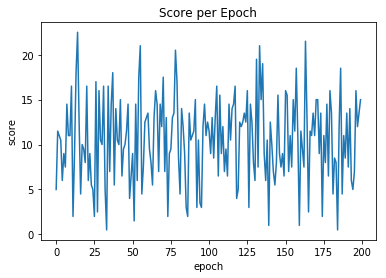

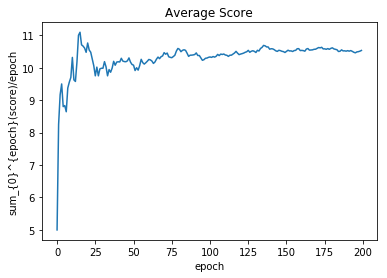

Final score: 10.5325


In [23]:
epochs_test = 200

env_mimick_test = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)

agent_mimick_test = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
agent_mimick_test.load(name_weights='cnn_train_mimickmodel.h5', name_model='cnn_train_mimickmodel.json')

test(agent_mimick_test, env_mimick_test, epochs_test, prefix='cnn_test_mimick')

HTML(display_videos('cnn_test_mimick'+str(epochs_test)+'.mp4'))

***